# Income Classficiation Prediction

In [1]:
import os
os.chdir('/root/kiva_crowdfunding')

In [28]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from src.merge_worldbank import load_data
from src.preprocessing import drop_col, classify_economy, has_female_borrower
import matplotlib.pyplot as plt
import numpy as np
 

## Dataset Set-up

In [12]:
loan = pd.read_csv('data/raw/kiva_loans.csv')
gdppc = load_data('data/raw/gdp_percapita.csv')

# Merge the datasets on 'Country Name'
merged_data = pd.merge(loan, gdppc, left_on='country', right_on='Country Name', how='left')

# Drop unnecessary columns
merged_data = drop_col(merged_data)

merged_data.head()

,funded_amount,loan_amount,sector,term_in_months,lender_count,borrower_genders,repayment_interval,Country Name,GDP per capita
0,300.0,300.0,Food,12.0,12,female,irregular,Pakistan,6036.650769
1,575.0,575.0,Transportation,11.0,14,"female, female",irregular,Pakistan,6036.650769
2,150.0,150.0,Transportation,43.0,6,female,bullet,India,10166.243411
3,200.0,200.0,Arts,11.0,8,female,irregular,Pakistan,6036.650769
4,400.0,400.0,Food,14.0,16,female,monthly,Pakistan,6036.650769


## Target Variable

Economies can be classified into low-income, middle-income (further divided into lower-middle and upper-middle), and high-income categories based on their GDP per capita.  The World Bank uses GNI per capita, which is similar to GDP per capita, to classify countries. For the target variable, I will use these labels as the variable to predict with the provided features. 

In [13]:
df = classify_economy(merged_data) 
df = df.dropna(subset=['GDP per capita', 'Income Group'])

## Preprocessing 

### Scaling Numerical Variables

#### Funded Amount and Loan Amount

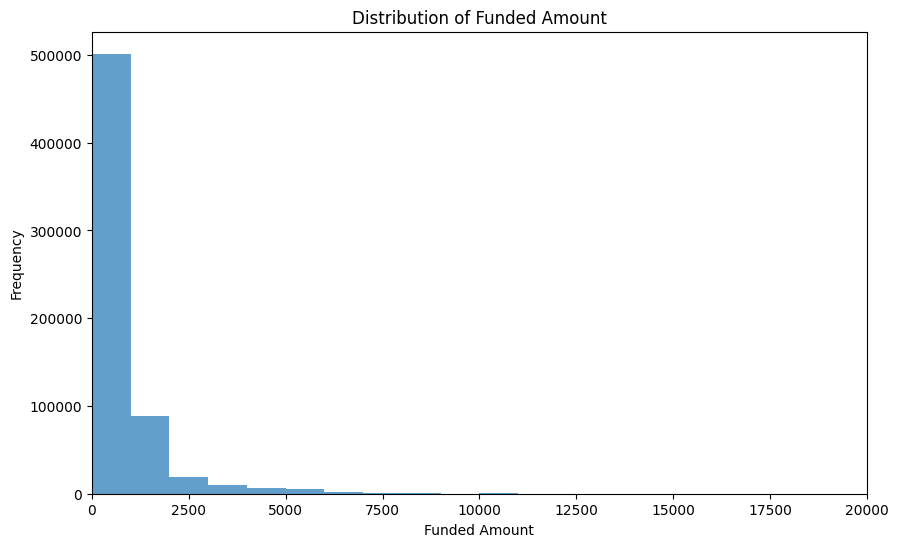

In [14]:
# Distribution of Funded Amount
df["funded_amount"].plot(kind='hist', bins=100, figsize=(10, 6), alpha=0.7)
plt.title('Distribution of Funded Amount')
plt.xlabel('Funded Amount')
plt.ylabel('Frequency')
plt.xlim(0, 20000)  # Adjust x-axis limit for better visibility
plt.show()

#### Term in Months

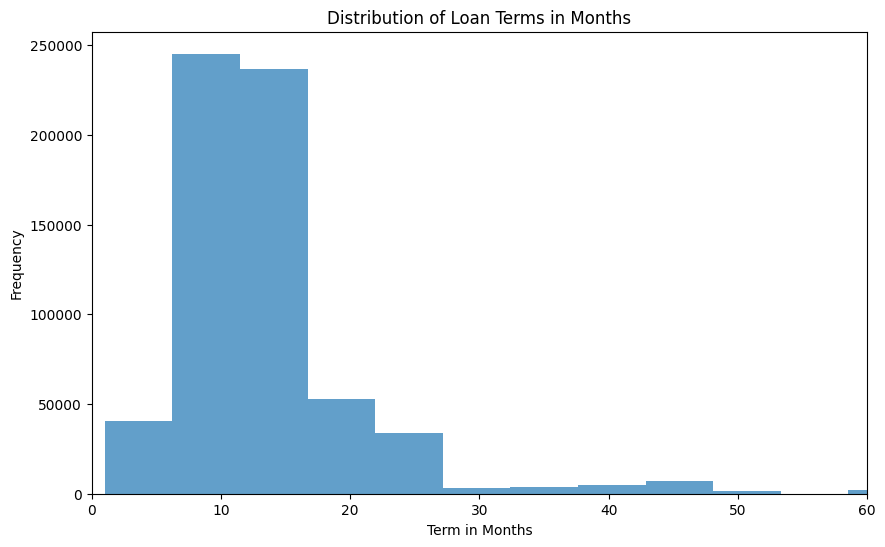

In [15]:
df['term_in_months'].plot(kind='hist', bins=30, figsize=(10, 6), alpha=0.7)
plt.title('Distribution of Loan Terms in Months')
plt.xlabel('Term in Months')
plt.ylabel('Frequency')
plt.xlim(0, 60)  # Adjust x-axis limit for better visibility
plt.show()

### Scaling

In [16]:
df['funded_amount_log'] = np.log1p(df['funded_amount'])
df['loan_amount_log'] = np.log1p(df['loan_amount'])

scaler = StandardScaler()
numerical_cols = ['funded_amount_log', 'loan_amount_log']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

/tmp/ipykernel_124544/3457066149.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['funded_amount_log'] = np.log1p(df['funded_amount'])
/tmp/ipykernel_124544/3457066149.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_amount_log'] = np.log1p(df['loan_amount'])
/tmp/ipykernel_124544/3457066149.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

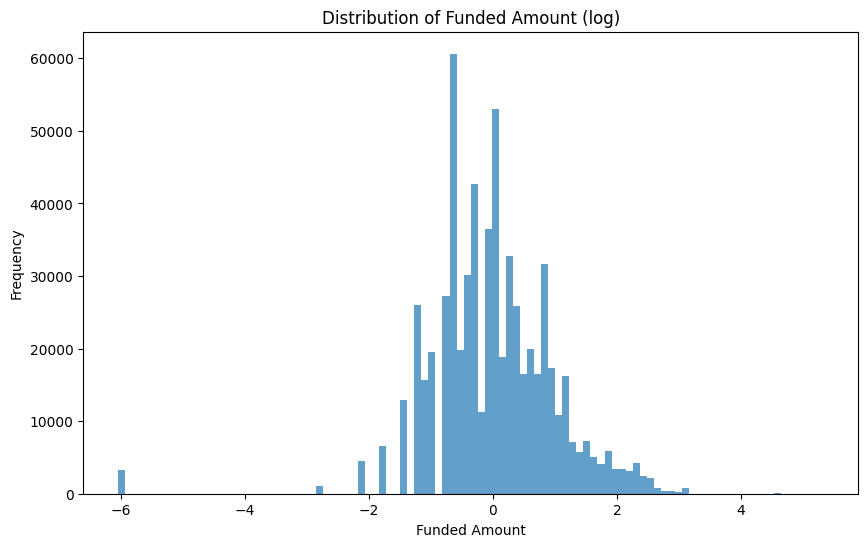

In [17]:
df["funded_amount_log"].plot(kind='hist', bins=100, figsize=(10, 6), alpha=0.7)
plt.title('Distribution of Funded Amount (log)')
plt.xlabel('Funded Amount')
plt.ylabel('Frequency')
plt.show()

### Categorical Variables

#### Gender Category 

In [18]:
df = has_female_borrower(df)

/root/kiva_crowdfunding/src/preprocessing.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["borrower_genders"] = df["borrower_genders"].fillna("")
/root/kiva_crowdfunding/src/preprocessing.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["has_female"] = df["borrower_genders"].apply(lambda x: int("female" in x.split(",")))


In [19]:
# Categorical Encoding
categorical_cols = ['sector', 'repayment_interval']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Encode the 'Income Group' column
label_encoder = LabelEncoder()
df['Income Group'] = label_encoder.fit_transform(df['Income Group'])

### Drop Rest of Variables

In [21]:
df = df.drop(columns=['funded_amount', 'loan_amount', 'borrower_genders', 'Country Name', 'GDP per capita'])

## Train Test Split

In [23]:
X = df.drop(columns=['Income Group'])
y = df['Income Group']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Model Building 

In [30]:
rf = RandomForestClassifier(random_state=42)

# Define parameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=2)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=2,
             param_grid={'max_depth': [None, 10], 'n_estimators': [100, 200]},
             scoring='accuracy')

## Prediction

In [31]:
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

y_pred = best_rf.predict(X_test)

Best Parameters: {'max_depth': None, 'n_estimators': 200}


## Evaluation

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.63      0.67     22205
           1       0.27      0.15      0.19       176
           2       0.62      0.49      0.55     15055
           3       0.86      0.92      0.89     89402

    accuracy                           0.82    126838
   macro avg       0.62      0.55      0.57    126838
weighted avg       0.81      0.82      0.81    126838

